In [1]:
import datetime
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import register_matplotlib_converters
from pyhive import hive
from modules.ModellingBasis import ModellingBasis
from modules.Cleaner import Cleaner

In [2]:
#database connection
conn = hive.Connection(host="192.168.1.241", port=10000, username="hive")

In [3]:
#use command
cursor = conn.cursor()
cursor.execute("use RoadNetwork")

In [4]:
#defining constant variables
fTag1 = "t1.flowvalue"
fTag2 = "t2.flowvalue"
dTag1 = "t1.measurementdatetime"
dTag2 = "t2.measurementdatetime"
sTag1 = "t1.speedvalue"
sTag2 = "t2.speedvalue"
kTag1 = "a.density"
kTag2 = "b.density"
timeRange = "2"

In [5]:
#testing variables
dateTimeFrom = "2020-02-03 00:00:00.0"
dateTimeTo = "2020-02-04 00:00:00.0"
referenceA = "RWS01_MONIBAS_0271hrr0779ra"
referenceB = "GEO1A_R_RWSTI4171"

In [6]:
#reading data set from database
stmt = "SELECT t1.measurementdatetime, t1.flowvalue, t1.speedValue, t2.measurementdatetime, t2.flowvalue, t2.speedValue FROM measurementpoint t1, measurementpoint t2  WHERE t1.measurementdatetime >= t2.measurementdatetime - interval '" + timeRange + "' minute AND t1.measurementdatetime <= t2.measurementdatetime + interval '" + timeRange + "' minute AND t1.reference = '" + referenceA + "' AND t2.reference = '" + referenceB + "' AND t1.measurementdatetime < '" + dateTimeTo + "' AND t1.measurementdatetime > '" + dateTimeFrom + "' AND t2.measurementdatetime < '" + dateTimeTo + "' AND  t2.measurementdatetime  > '" + dateTimeFrom + "' ORDER BY t1.measurementdatetime"
data = pd.read_sql(stmt, conn)

In [7]:
data.head()

,t1.measurementdatetime,t1.flowvalue,t1.speedvalue,t2.measurementdatetime,t2.flowvalue,t2.speedvalue
0,2020-02-03 00:01:00,360.0,100.000000,2020-02-03 00:02:00,0.0,0.0
1,2020-02-03 00:07:00,480.0,90.666667,2020-02-03 00:08:00,0.0,0.0
2,2020-02-03 00:12:00,120.0,101.000000,2020-02-03 00:13:00,0.0,0.0
3,2020-02-03 00:18:00,240.0,117.250000,2020-02-03 00:19:00,0.0,0.0
4,2020-02-03 00:24:00,120.0,112.500000,2020-02-03 00:25:00,0.0,0.0


In [8]:
def clean(data, fTag, sTag):
    
    # dividing dataset into quantiles
    flowInterval1 = data.quantile(0.25)[fTag]
    flowInterval2 = data.quantile(0.50)[fTag]
    flowInterval3 = data.quantile(0.75)[fTag]
    flowInterval4 = data.quantile(1)[fTag]

    # defining mean variables for each of the quantile intervals
    flowMean1 = 0
    flowMean2 = 0
    flowMean3 = 0

    # as the sets may be unequally sized we define element count variables as well
    n1 = 0
    n2 = 0
    n3 = 0

    # getting the means of the three different intervals
    for index, row in data.iterrows():
        if (str(row[fTag]) != 'NaT'):
            if (row[fTag] > flowInterval1 and row[fTag] <= flowInterval2):
                flowMean1 = flowMean1 + row[fTag]
                n1 = n1 + 1
            elif (row[fTag] > flowInterval2 and row[fTag] <= flowInterval3):
                flowMean2 = flowMean2 + row[fTag]
                n2 = n2 + 1
            elif (row[fTag] > flowInterval3 and row[fTag] <= flowInterval4):
                flowMean3 = flowMean3 + row[fTag]
                n3 = n3 + 1

    if (n1 != 0):
        flowMean1 = flowMean1 / n1
    if (n2 != 0):
        flowMean2 = flowMean2 / n2
    if (n3 != 0):
        flowMean3 = flowMean3 / n3

    # cleaning flow data
    for index, row in data.iterrows():
        # first check if the zero value must be changed
        # the zero values which have the previous neighbor value above the first quantile will be changed
        if (row[fTag] == 0 or str(row[fTag]) == 'NaT'):
            if (index > 0):  # preventing from index out of bounds error
                if (data.iloc[[index - 1][0]][
                    fTag] > flowInterval1):  # checking if the value is extremely low
                    if (data.iloc[[index - 1][0]][
                        fTag] > flowInterval3):  # checking the quantile which the previous neighbor belongs
                        data.set_value(index, fTag, flowMean3)
                    elif (data.iloc[[index - 1][0]][fTag] > flowInterval2):
                        data.set_value(index, fTag, flowMean2)
                    else:
                        data.set_value(index, fTag, flowMean1)

    speedMean = data[data[sTag] > 0].mean()[sTag]  # mean

    # speed data cleaning
    for index, row in data.iterrows():
        if (row[sTag] <= 0):
            data.set_value(index, sTag, speedMean)
    
    return data

In [9]:
data = clean(data, fTag1, sTag1)
data = clean(data, fTag2, sTag2)

/home/oem/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/home/oem/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/home/oem/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


# Flow regression

/home/oem/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


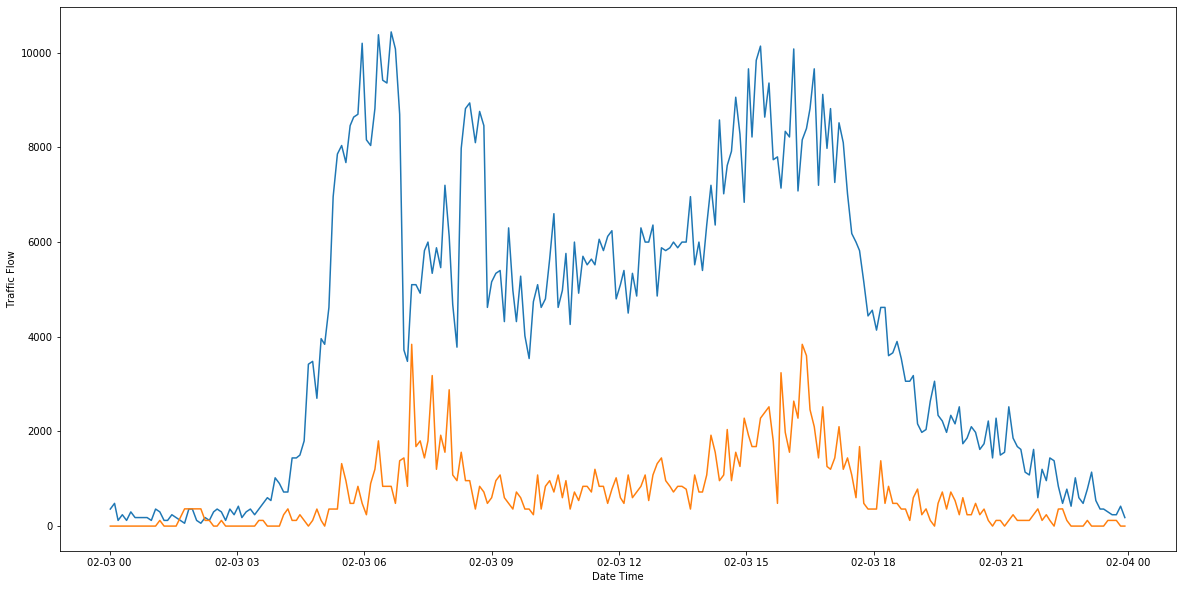

In [10]:
#plotting data from the two measurement points
plt.plot(data[dTag1], data[fTag1])
plt.plot(data[dTag1], data[fTag2])
plt.xlabel("Date Time")
plt.ylabel("Traffic Flow")
fig = plt.gcf()
fig.set_size_inches(20, 10)
plt.show()

In [11]:
#print correlation between flows 
data[fTag1].corr(data[fTag2])

0.6985589677678319

In [12]:
X = data.iloc[:, 1].values.reshape(-1, 1)  # values converts it into a numpy array
Y = data.iloc[:, 4].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions

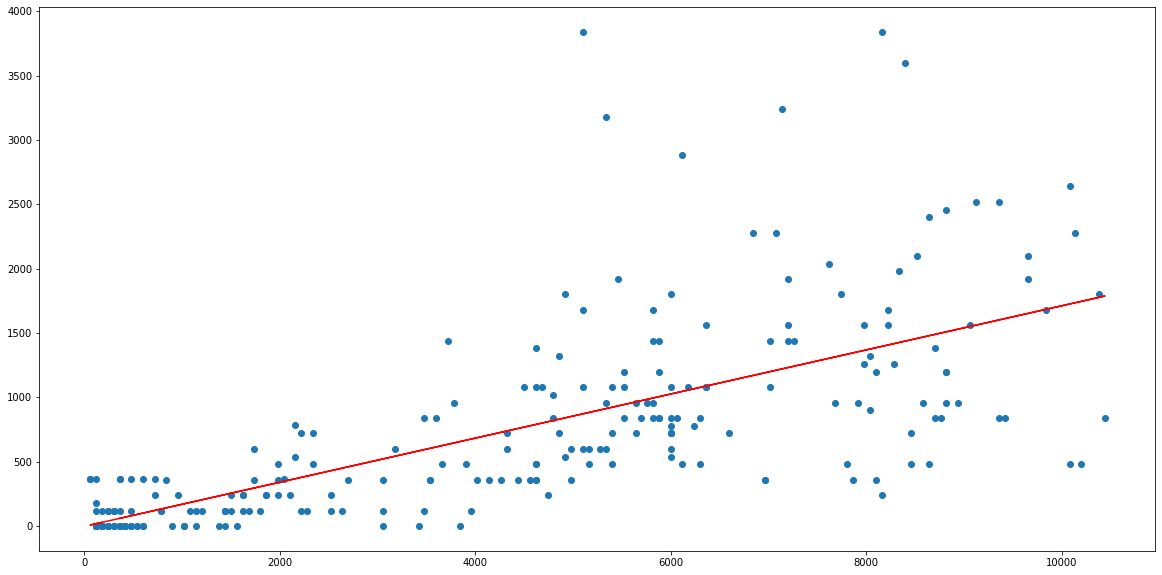

In [13]:
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
fig = plt.gcf()
fig.set_size_inches(20, 10)
plt.show()

# Speed regression

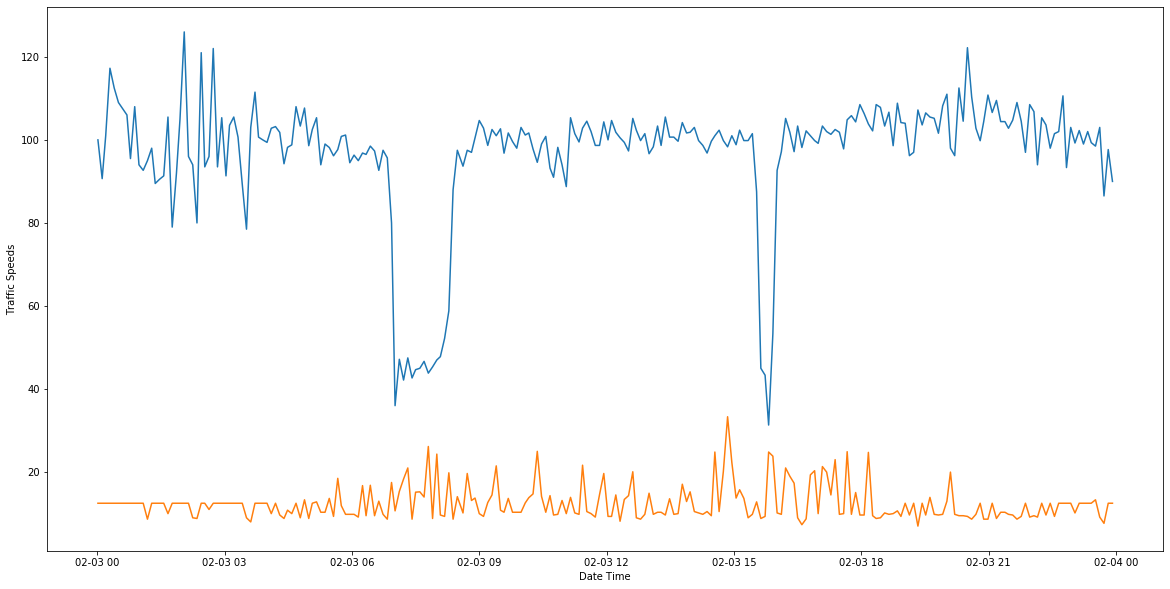

In [14]:
#plotting data from the two measurement points
plt.plot(data[dTag1], data[sTag1])
plt.plot(data[dTag1], data[sTag2])
plt.xlabel("Date Time")
plt.ylabel("Traffic Speeds")
plt.rcParams['figure.figsize'] = [25,10]
fig = plt.gcf()
fig.set_size_inches(20, 10)
plt.show()

In [15]:
data[sTag1].corr(data[sTag2])

-0.2078522703568538

In [16]:
X = data.iloc[:, 2].values.reshape(-1, 1)  # values converts it into a numpy array
Y = data.iloc[:, 5].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions

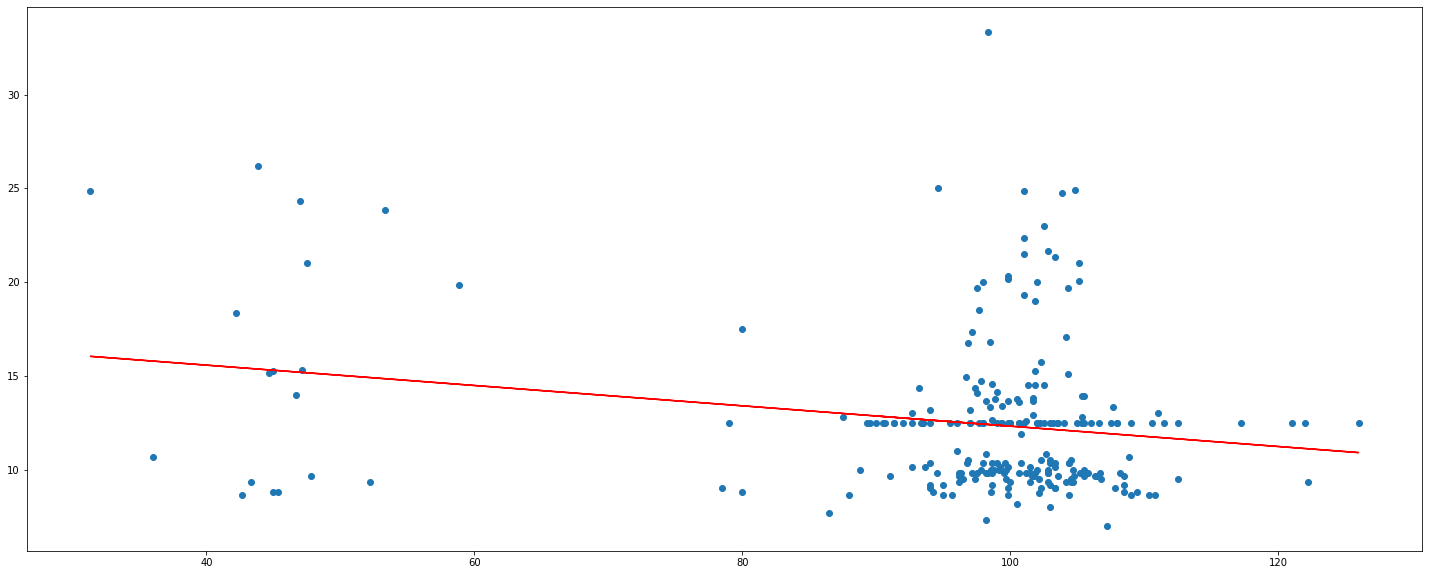

In [17]:
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()

# Density regression

In [18]:
#calculate densities
densityDF = pd.DataFrame(columns = [kTag1, kTag2])

for index, row in data.iterrows():
    dA = row[fTag1] / row[sTag1]
    dB = row[fTag2] / row[sTag2]
    auxDF = pd.DataFrame([[dA, dB]], columns = [kTag1, kTag2])
    densityDF = densityDF.append(auxDF, ignore_index = True)

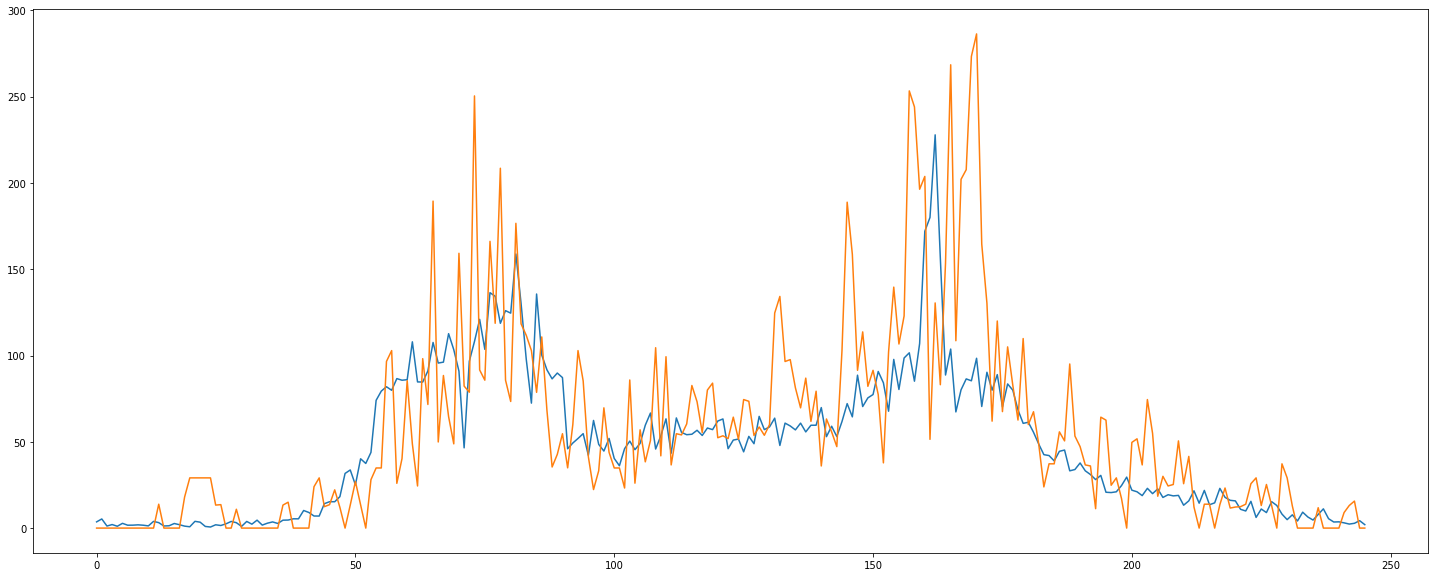

In [19]:
plt.plot(densityDF[kTag1])
plt.plot(densityDF[kTag2])
plt.show()

In [20]:
densityDF[kTag1].corr(densityDF[kTag2])

0.7124150249327172

In [21]:
X = densityDF.iloc[:, 0].values.reshape(-1, 1)  # values converts it into a numpy array
Y = densityDF.iloc[:, 1].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions

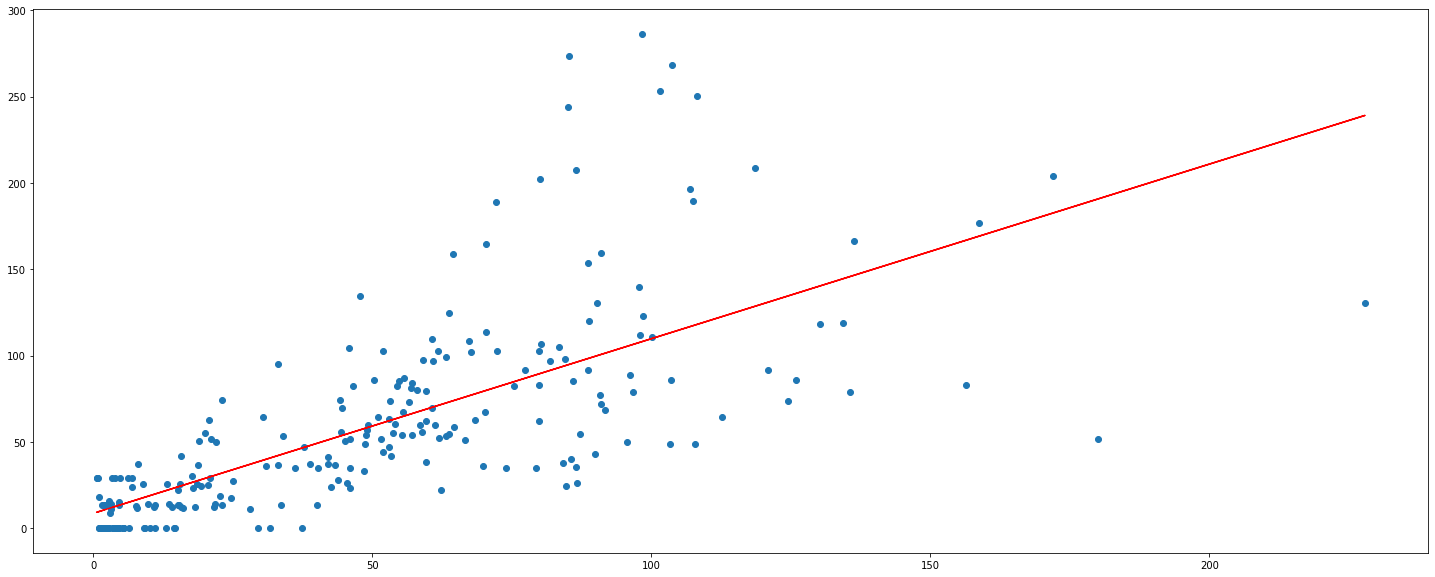

In [22]:
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()

# Boxplot comparison

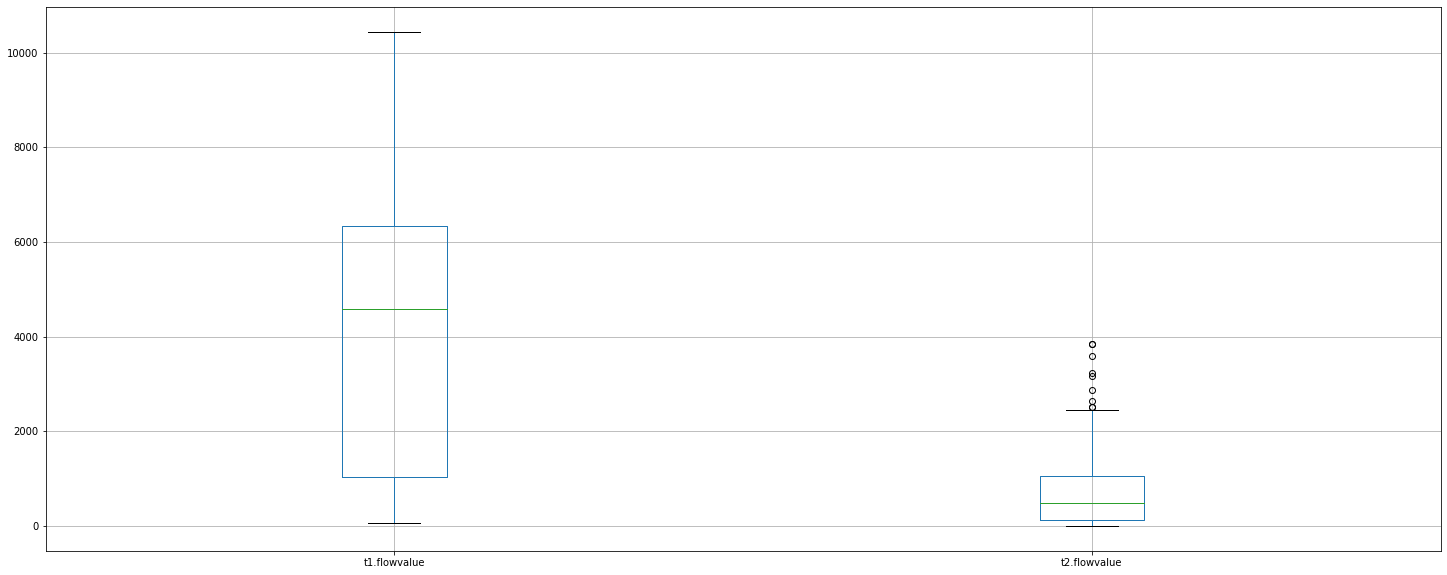

In [23]:
data.boxplot(column = [fTag1, fTag2])

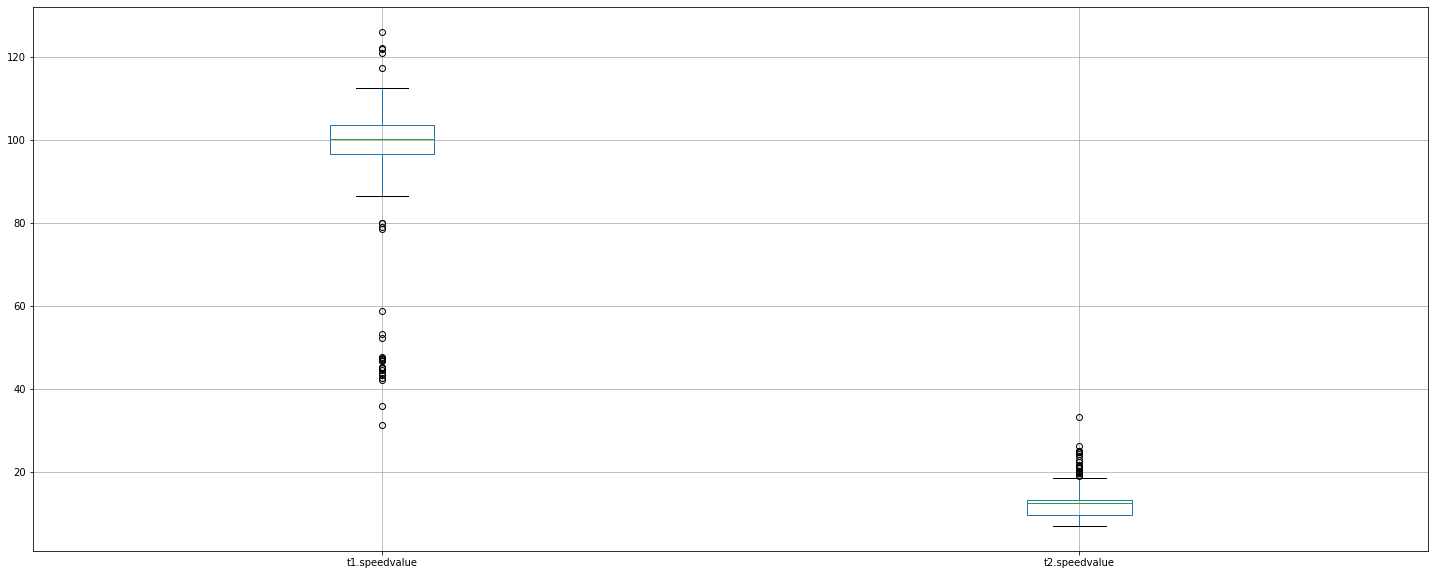

In [24]:
data.boxplot(column = [sTag1, sTag2])

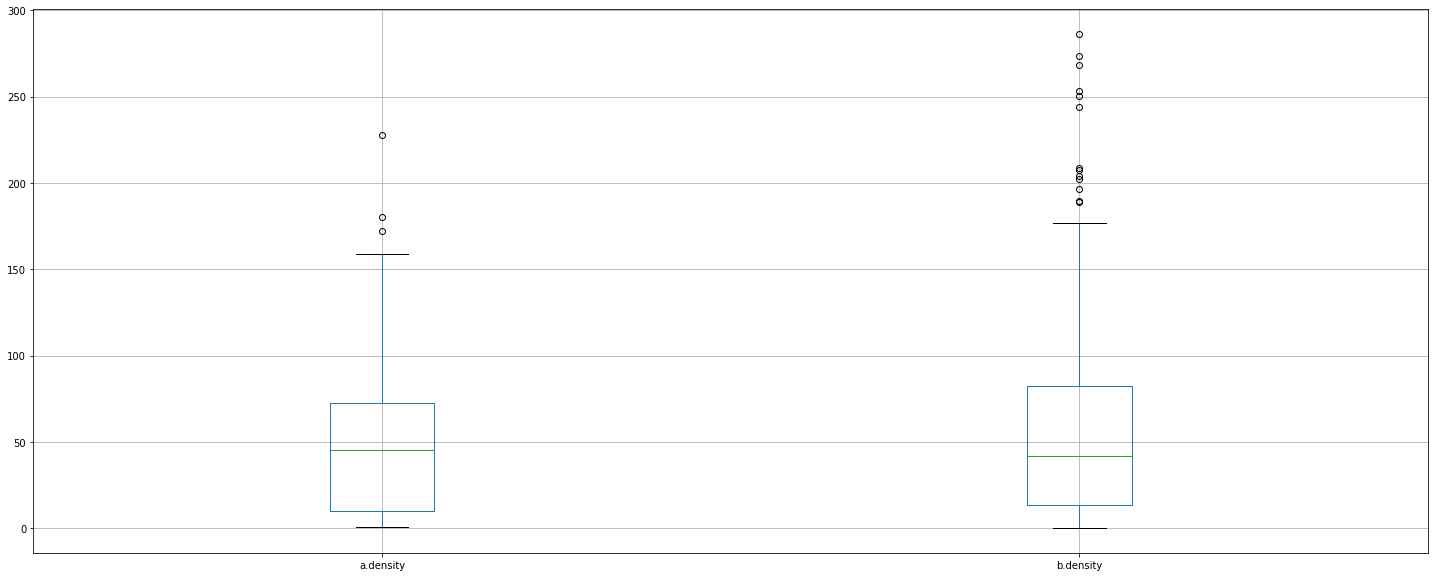

In [25]:
densityDF.boxplot(column = [kTag1, kTag2])

# Modelling comparison

In [26]:
# dates for the modelling
datesList = [("2019-11-26 00:00:00.0", "2019-11-30 00:00:00.0"), ("2019-12-02 00:00:00.0", "2019-12-06 00:00:00.0"), ("2019-12-10 00:00:00.0", "2019-12-11 00:00:00.0"), ("2019-12-19 00:00:00.0", "2019-12-21 00:00:00.0"), ("2019-12-23 00:00:00.0", "2019-12-25 00:00:00.0"), ("2019-12-02 00:00:00.0", "2019-12-06 00:00:00.0"), ("2019-12-10 00:00:00.0", "2019-12-11 00:00:00.0"), ("2019-12-19 00:00:00.0", "2019-12-21 00:00:00.0"), ("2020-01-02 00:00:00.0", "2020-01-04 00:00:00.0"), ("2020-01-14 00:00:00.0", "2020-01-18 00:00:00.0"), ("2020-01-20 00:00:00.0", "2020-01-25 00:00:00.0"), ("2020-01-27 00:00:00.0", "2020-02-01 00:00:00.0")]

In [ ]:

#generating sql statements 
sql = "SELECT measurementdatetime, flowvalue, speedvalue FROM MeasurementPoint WHERE"
for i in datesList:
    startDate = i[0]
    endDate = i[1]
    sql = sql + " reference = '" + referenceA + "' AND measurementdatetime > '" + startDate + "' AND measurementdatetime < '" + endDate + "' OR"
sql = sql[:-3]
sql = sql + " order by measurementdatetime"

#reading data set from database
data_A = pd.read_sql(sql, conn)

#generating sql statements 
sql = "SELECT measurementdatetime, flowvalue, speedvalue FROM MeasurementPoint WHERE"
for i in datesList:
    startDate = i[0]
    endDate = i[1]
    sql = sql + " reference = '" + referenceB + "' AND measurementdatetime > '" + startDate + "' AND measurementdatetime < '" + endDate + "' OR"
sql = sql[:-3]
sql = sql + " order by measurementdatetime"

#reading data set from database
data_B = pd.read_sql(sql, conn)

In [ ]:
mb_A = ModellingBasis(data_A)
mb_B = ModellingBasis(data_B)

In [ ]:
flow_model_A = mb_A.flow_model
flow_model_B = mb_B.flow_model

In [ ]:
plt.plot(mb_A.flowDF["measurementdatetime"], flow_model_A(range(mb_A.flowDF.shape[0])))
plt.plot(mb_B.flowDF["measurementdatetime"], flow_model_B(range(mb_B.flowDF.shape[0])))

In [ ]:
density_model_A = mb_A.density_model
density_model_B = mb_B.density_model

In [ ]:
plt.plot(mb_A.flowDF["measurementdatetime"], density_model_A(range(mb_A.flowDF.shape[0])))
plt.plot(mb_B.flowDF["measurementdatetime"], density_model_B(range(mb_B.flowDF.shape[0])))